In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import Packages

In [ ]:
import time
import numpy as np
import os
import cv2
import random
import pickle
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

##Load Dataset

In [5]:
# Define labels of the classes and subclasses

CLASSES = ["healthy", "ill"]
SUBCLASSES = ["fever", "sore throat", "running nose"]

In [6]:
folder = "/content/drive/MyDrive/FYP/dataset"
img_array = []
class_num_list1 = []
subcls_num_list1 = ["None"]*500   # fill the list with 500 "None's" first to represent "healthy" samples

for c in CLASSES: 
        
    if (c == "healthy"):
        path = os.path.join(folder,c)  # create path to dataset folder
        class_num = 0  # get the CLASSES index, 0 = healthy, 1 = ill
        for img in tqdm(os.listdir(path)):  # iterate over each image per folder
            try:
                img = cv2.imread(os.path.join(path,img))  # read image into a list 
                img_array.append(img)
                class_num_list1.append(class_num) # save a list of the class numbers
            except Exception as e: 
                print("error")
                
    elif (c == "ill"):
        for s in SUBCLASSES:
            path = os.path.join(folder,c,s) # create path to ill subfolders 
            class_num = 1
            subclass_num = SUBCLASSES.index(s)
            for img in tqdm(os.listdir(path)):  # iterate over each image per folder
                try:
                    img = cv2.imread(os.path.join(path,img))  # read image into a list
                    img_array.append(img)
                    class_num_list1.append(class_num) 
                    subcls_num_list1.append(subclass_num) # save a list of the subclass numbers; 0 = fever, 1 = sore throat, 2 = running nose
                except Exception as e: 
                    print("error")

In [7]:
folder_aug = "/content/drive/MyDrive/FYP/augmented images"
aug_array = []
class_num_list2 = []
subcls_num_list2 = ["None"]*500 # fill the list with 500 "None's" first to represent "healthy" samples

for c in CLASSES: 
        
    if (c == "healthy"):
        path = os.path.join(folder_aug,c)  # create path to dataset folder_aug
        class_num = 0  # get the CLASSES index, 0 = healthy, 1 = ill
        for img in tqdm(os.listdir(path)):  # iterate over each image per folder_aug
            try:
                img = cv2.imread(os.path.join(path,img))  # read image into a list 
                aug_array.append(img)
                class_num_list2.append(class_num) # save a list of the class numbers
            except Exception as e: 
                print("error")
                
    elif (c == "ill"):
        for s in SUBCLASSES:
            path = os.path.join(folder_aug,c,s) # create path to ill subfolder_augs 
            class_num = 1
            subclass_num = SUBCLASSES.index(s)
            for img in tqdm(os.listdir(path)):  # iterate over each image per folder_aug
                try:
                    img = cv2.imread(os.path.join(path,img))  # read image into a list
                    aug_array.append(img)
                    class_num_list2.append(class_num) 
                    subcls_num_list2.append(subclass_num) # save a list of the subclass numbers; 0 = fever, 1 = sore throat, 2 = running nose
                except Exception as e: 
                    print("error")

In [8]:
# Combine the original and augmented images into a new list

all_imgs = []

all_imgs = img_array.copy()

for i, img in enumerate(aug_array):
    all_imgs.append(img)

print(len(all_imgs))

1466


## Feature Extraction

In [9]:
# Apply Gabor filter to extract features
def build_filters():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters
 
def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum

In [10]:
# Extract all features from the whole dataset

all_gab_features = []

for img in tqdm(all_imgs):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert color image to grayscale
    filters = build_filters()
    extracted = process(img, filters)
    all_gab_features.append(extracted)

In [11]:
# Separate the features of augmented images from original images
# to prevent information leakage during splitting 

aug_gab_features = []
gab_features = []

for j in range(len(all_gab_features)):
    if(j >= 733):
        aug_gab_features.append(all_gab_features[j])
    else:
        gab_features.append(all_gab_features[j])

print(len(gab_features))
print(len(aug_gab_features))

733
733


## First-Level Classification
> ### *Classify samples into healthy (0) and ill (1) classes*


In [12]:
# Create partial dataset with features of original images (will add in the augmented set after spliting)
dataset = []

for i, features in enumerate(gab_features):  
    try:
        img_gray = cv2.cvtColor(img_array[i], cv2.COLOR_BGR2GRAY)
        dataset.append([features, class_num_list1[i], subcls_num_list1[i], img_gray])
    except Exception as e: 
        print("error")

In [13]:
# Create the augmented images' dataset 
aug_dataset = []

for i, aug_features in enumerate(aug_gab_features):  
    try:
        aug_gray = cv2.cvtColor(aug_array[i], cv2.COLOR_BGR2GRAY)
        aug_dataset.append([aug_features, class_num_list2[i], subcls_num_list2[i], aug_gray])
    except Exception as e: 
        print("error")

In [50]:
# Split the original dataset
train_set_before, test_set = train_test_split(dataset, test_size=0.2, shuffle=True)

print('Train set length before data augmentation: ', len(train_set_before))
print('Test set length: ', len(test_set))

Train set length before data augmentation:  586
Test set length:  147


In [51]:
# Add the augmented dataset into the training set, then shuffle
train_set = []

train_set = train_set_before.copy()

for aug_set in aug_dataset:  
    if (len(train_set) < 1319):
        train_set.append(aug_set)
        
random.shuffle(train_set)
len(train_set)

1319

In [52]:
# Create training set

X_train = []
y_train = []
gray_img1 = []
subcls_num = []

for features, label, subcls, gray in train_set:
    X_train.append(features)
    y_train.append(label)
    gray_img1.append(gray)
    subcls_num.append(subcls)

X_train = np.array(X_train).reshape(len(y_train), -1)
y_train = np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(1319, 40000)
(1319,)


In [53]:
# Create testing set

X_test = []
y_test = []
gray_img2 = []

for features, label, subcls, gray in test_set:
    X_test.append(features)
    y_test.append(label)
    gray_img2.append(gray)

X_test = np.array(X_test).reshape(len(y_test), -1)
y_test = np.array(y_test)

print(X_test.shape)
print(y_test.shape)

(147, 40000)
(147,)


### Train Model

In [54]:
# Train the classifier

rf = RandomForestClassifier(n_estimators=1200,
                            n_jobs=-1, 
                            random_state=None)

start_train = time.time() # to record the training time
rf.fit(X_train, y_train)
end_train = time.time()
print(end_train - start_train, "seconds")

152.54165363311768 seconds


#### Training Performance

In [55]:
y_pred = rf.predict(X_train)

ill_pred = y_pred

print("Classification report for - \n{}:\n{}\n".format(
    rf, metrics.classification_report(y_train, y_pred)))

train_acc = metrics.accuracy_score(y_train, y_pred)*100
print("Training accuracy: " + str(train_acc))

Classification report for - 
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       902
           1       1.00      1.00      1.00       417

    accuracy                           1.00      1319
   macro avg       1.00      1.00      1.00      1319
weighted avg       1.00      1.00      1.00      1319


Training accuracy: 100.0


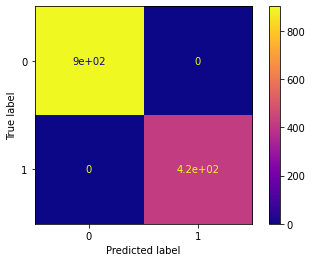

In [56]:
plot_confusion_matrix(rf, X_train, y_train, cmap='plasma')

#### Testing Performance

In [57]:
y_pred = rf.predict(X_test)

print("Classification report for - \n{}:\n{}\n".format(
    rf, metrics.classification_report(y_test, y_pred)))

test_acc = metrics.accuracy_score(y_test, y_pred)*100
print("Testing accuracy: " + str(test_acc))

Classification report for - 
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False):
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        98
           1       1.00      0.61      0.76        49

    accuracy                           0.87       147
   macro avg       0.92      0.81      0.84       147
weighted avg       0.89      0.87      0.86       147


Testing accuracy: 87.07482993197279


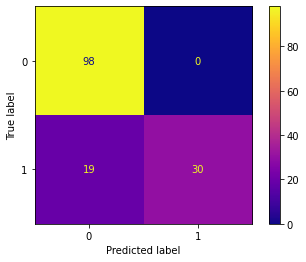

In [58]:
plot_confusion_matrix(rf, X_test, y_test, cmap='plasma')

In [59]:
# Get wrongly classified samples
def get_wrong_case(pred_result, test_result):
    
    for i in range(len(pred_result)):
        predicted = pred_result[i]
        actual = test_result[i]
        if(actual != predicted):
            wrong_case.append([i,predicted,actual])

In [83]:
def plot(wrong_case, row, col, gray, labels):
    
    if (labels == SUBCLASSES):
        fsize = 18
        top = 5
        bottom = 4
    else:
        fsize = 20
        top = 3
        bottom = 2.7
        
    
    plt.figure(figsize=(40, 40))
    plt.subplots_adjust(top=top, bottom=bottom)
    
    for i in range(len(wrong_case)):
        plt.subplot(row, col, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        title = str(i+1) + '. Predicted: ' + labels[wrong_case[i][1]] + '\nActual: ' + labels[wrong_case[i][2]]
        plt.title(title, fontdict = {'fontsize' : fsize})
        plt.imshow(gray[wrong_case[i][0]], cmap='gray')

    plt.show()
    
    print("The number of misclassified images: ")
    print(len(wrong_case))

In [77]:
wrong_case = []
get_wrong_case(y_pred, y_test)

## Second-Level Classification
> ### *Classify  'ill' cases into fever (0), sore throat (1) and running nose (2) subclasses*



In [63]:
ill_case_index = []
ill_dataset = []

In [64]:
# Get the indexes of samples correctly classified as "ill"

for i, a in enumerate(ill_pred):
    if((ill_pred[i] == 1) and (ill_pred[i] == y_train[i]) and (subcls_num[i] != "None")):  # 1 = ill, filter out the cases with "healthy" true labels
        ill_case_index.append(i) # save the indexes of ill cases

In [65]:
# Create dataset for second-level classification

for a in ill_case_index:
    ill_dataset.append([X_train[a], subcls_num[a], gray_img1[a]])
    
ill_dataset = np.array(ill_dataset, dtype=object)

In [66]:
train_ill_set, test_ill_set = train_test_split(ill_dataset, test_size=0.3, shuffle=True)

print('Train set length: ', len(train_ill_set))
print('Test set length: ', len(test_ill_set))

Train set length:  291
Test set length:  126


In [67]:
X_train_ill = []
y_train_ill = []
gray_img_ill1 = []

for features, label, gray in train_ill_set:
    X_train_ill.append(features)
    y_train_ill.append(label)
    gray_img_ill1.append(gray)

X_train_ill = np.array(X_train_ill).reshape(len(y_train_ill), -1)
y_train_ill = np.array(y_train_ill)

print(X_train_ill.shape)
print(y_train_ill.shape)

(291, 40000)
(291,)


In [68]:
X_test_ill = []
y_test_ill = []
gray_img_ill2 = []

for features, label, gray in test_ill_set:
    X_test_ill.append(features)
    y_test_ill.append(label)
    gray_img_ill2.append(gray)

X_test_ill = np.array(X_test_ill).reshape(len(y_test_ill), -1)
y_test_ill = np.array(y_test_ill)

print(X_test_ill.shape)
print(y_test_ill.shape)

(126, 40000)
(126,)


### Train Model

In [69]:
# Train the classifier

rf = RandomForestClassifier(n_estimators=1200,
                            n_jobs=-1, 
                            random_state=None)

start_train_ill = time.time()
rf.fit(X_train_ill, y_train_ill)
end_train_ill = time.time()
print(end_train_ill - start_train_ill, "seconds")

21.11966347694397 seconds


#### Training Performance

In [70]:
y_pred_ill = rf.predict(X_train_ill)

print("Classification report for - \n{}:\n{}\n".format(
    rf, metrics.classification_report(y_train_ill, y_pred_ill)))

train_ill_acc = metrics.accuracy_score(y_train_ill, y_pred_ill)*100
print("Training accuracy: " + str(train_ill_acc))

Classification report for - 
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        98
           1       1.00      1.00      1.00        95
           2       1.00      1.00      1.00        98

    accuracy                           1.00       291
   macro avg       1.00      1.00      1.00       291
weighted avg       1.00      1.00      1.00       291


Training accuracy: 100.0


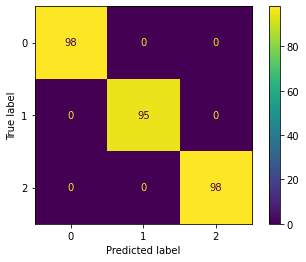

In [71]:
plot_confusion_matrix(rf, X_train_ill, y_train_ill, cmap='viridis')

#### Testing Performance

In [72]:
y_pred_ill = rf.predict(X_test_ill)

print("Classification report for - \n{}:\n{}\n".format(
    rf, metrics.classification_report(y_test_ill, y_pred_ill)))

test_ill_acc = metrics.accuracy_score(y_test_ill, y_pred_ill)*100
print("Testing accuracy: " + str(test_ill_acc))

Classification report for - 
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False):
              precision    recall  f1-score   support

           0       0.63      0.62      0.63        42
           1       0.84      0.79      0.82        48
           2       0.53      0.58      0.55        36

    accuracy                           0.67       126
   macro avg       0.67      0.66      0.67       126
weighted avg       0.68      0.67      0.68       126


Testing accuracy: 67.46031746031747


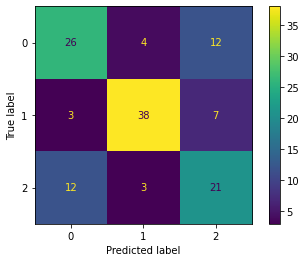

In [73]:
plot_confusion_matrix(rf, X_test_ill, y_test_ill, cmap='viridis')

In [74]:
wrong_case = []
get_wrong_case(y_pred_ill, y_test_ill)

In [75]:
# To visualise misclassified samples
col = 9
row = len(wrong_case) / col + len(wrong_case) % 9

plot(wrong_case, row, col, gray_img_ill2, SUBCLASSES)

Output hidden; open in https://colab.research.google.com to view.